In [1]:
!pip install xgboost

In [2]:
!pip install lightgbm

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

import seaborn as sns
df = sns.load_dataset('titanic').copy()

y = df['survived'].astype(int)
X = df.drop(columns=['survived'])

num_feats = ['age','fare','sibsp','parch', 'pclass']
cat_feats = ['sex', 'embarked','class','who','adult_male','alone']

In [5]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [8]:
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler(with_mean=False))
])

categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, num_feats),
    ('cat', categorical_pipe, cat_feats)
],
                               remainder='drop'
                               )

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [10]:
models = {
    'LogReg': LogisticRegression(max_iter=2000, n_jobs=None),
    'RandomForest': RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_leaf=2, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=800,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1

    ),
    'LightGBM': LGBMClassifier(
        objective='binary',
        n_estimators=1500,
        learning_rate=0.1,
        num_leaves=63,
        max_bin=500,
        min_child_samples=10,
        min_child_weight=1e-4,
        min_split_gain=0.0,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        force_row_wise=True,
        class_weight=None,
        random_state=42,
        n_jobs=-1

    )
}

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'logloss':'neg_log_loss',
    'accuracy':'accuracy',
    'roc_auc':'roc_auc'
}

cv_results = []

for name, clf in models.items():
  pipe = Pipeline([
      ('prep',preprocess),
      ('clf',clf)
  ])

  cv = cross_validate(pipe, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False)
  cv_results.append({
      'model':name,
      'logloss_mean': -cv['test_logloss'].mean(),
      'logloss_std':cv['test_logloss'].std(),
      'roc_auc_mean': cv['test_roc_auc'].mean(),
      'accuracy_mean': cv['test_accuracy'].mean()
  })

cv_table = pd.DataFrame(cv_results).sort_values('logloss_mean')
cv_table

,model,logloss_mean,logloss_std,roc_auc_mean,accuracy_mean
1,RandomForest,0.406291,0.024467,0.884683,0.841755
0,LogReg,0.423345,0.021079,0.865971,0.822666
3,XGBoost,0.466806,0.047957,0.875023,0.817049
2,GradientBoosting,0.480024,0.063072,0.877516,0.820382
4,LightGBM,1.218874,0.209305,0.854860,0.802436


In [15]:
df['survived'].mean()

np.float64(0.3838383838383838)

# Resampling

In [16]:
df = pd.read_csv('credit_dataset.csv')

In [21]:
df = df.iloc[:,1:]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25134 entries, 0 to 25133
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              25134 non-null  int64  
 1   GENDER          25134 non-null  object 
 2   CAR             25134 non-null  object 
 3   REALITY         25134 non-null  object 
 4   NO_OF_CHILD     25134 non-null  int64  
 5   INCOME          25134 non-null  float64
 6   INCOME_TYPE     25134 non-null  object 
 7   EDUCATION_TYPE  25134 non-null  object 
 8   FAMILY_TYPE     25134 non-null  object 
 9   HOUSE_TYPE      25134 non-null  object 
 10  FLAG_MOBIL      25134 non-null  int64  
 11  WORK_PHONE      25134 non-null  int64  
 12  PHONE           25134 non-null  int64  
 13  E_MAIL          25134 non-null  int64  
 14  FAMILY SIZE     25134 non-null  float64
 15  BEGIN_MONTH     25134 non-null  int64  
 16  AGE             25134 non-null  int64  
 17  YEARS_EMPLOYED  25134 non-null 

In [23]:
df['TARGET'].mean()

np.float64(0.01679000557014403)

In [27]:
minority = df[df['TARGET']==1]
majority = df[df['TARGET']==0]

<Axes: xlabel='INCOME', ylabel='Count'>

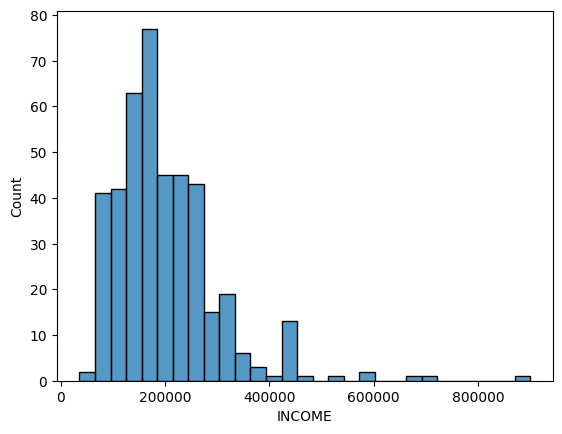

In [30]:
sns.histplot(minority['INCOME'])


<Axes: xlabel='INCOME', ylabel='Count'>

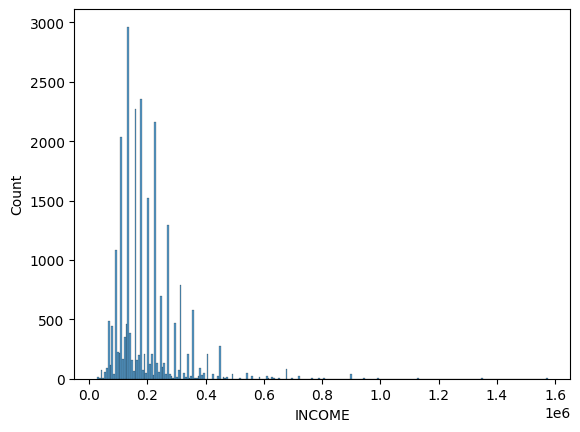

In [31]:
sns.histplot(majority['INCOME'])

In [35]:
minority.groupby('EDUCATION_TYPE')['ID'].count()/len(minority)

,ID
EDUCATION_TYPE,
Higher education,0.303318
Incomplete higher,0.049763
Lower secondary,0.014218
Secondary / secondary special,0.632701


In [37]:
majority.groupby('EDUCATION_TYPE')['ID'].count()/len(majority)

,ID
EDUCATION_TYPE,
Academic degree,0.000567
Higher education,0.283425
Incomplete higher,0.039333
Lower secondary,0.007324
Secondary / secondary special,0.669351


In [38]:
pip install imblearn

In [39]:
from imblearn.over_sampling import RandomOverSampler

In [40]:
from imblearn.under_sampling import RandomUnderSampler

In [41]:
from imblearn.over_sampling import SMOTE

In [47]:
X.dropna(inplace=True)

In [53]:
y= y.loc[X.index.to_list()]

In [58]:
X = X[['pclass','age','fare']]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
smote = SMOTE(random_state=42, k_neighbors=5)

In [61]:
X_res, y_res = smote.fit_resample(X_train, y_train)

In [62]:
X_res

,pclass,age,fare
0,1,45.500000,28.500000
1,1,29.000000,66.600000
2,2,3.000000,26.000000
3,3,25.000000,7.650000
4,1,37.000000,52.554200
...,...,...,...
193,1,40.226192,55.994611
194,1,20.969774,51.596599
195,1,5.422414,159.756950
196,1,16.335857,151.550000


In [63]:
X

,pclass,age,fare
1,1,38.0,71.2833
3,1,35.0,53.1000
6,1,54.0,51.8625
10,3,4.0,16.7000
11,1,58.0,26.5500
...,...,...,...
871,1,47.0,52.5542
872,1,33.0,5.0000
879,1,56.0,83.1583
887,1,19.0,30.0000
